In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys
sys.path.insert(0, '/nfs/privileged/isalazar/projects/ultrasound-image-formation/')
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from exploration.EMBC2024.cross_experiment.train import load_model as load_nair_model
from exploration.advtraining.ifsr001_nair_advTrain import load_model as load_nairAdv_model
from strohm_train import load_model as load_strohm_model
from wang_train import load_wang_model
from src.US_data import LoadData_phantomLIM_ATSmodel539, LoadDataPICMUS
from src.beamforming_utils import make_pixel_grid_from_pos
from utils import downsample_channel_data, compute_metrics
from src.beamforming_DAS import make_bimg_das1
from train_utils import create_dir
import h5py
from src.US_data import PlaneWaveData
from scipy.signal import hilbert
from pytorch_msssim import MS_SSIM
from skimage.restoration import denoise_nl_means


In [2]:
from all_reconstructions_shape_variation import ShapeVariationDataLoader

In [3]:
this_dir = 'C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/'
basic_dataset_dir = 'C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/sample_data/naturalPerturbations/'
h5_dataset_dir = f'{basic_dataset_dir}/shape/v1.0'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# ------ MODEL SET-UP
epoch = 99
model_nair, _ = load_nair_model(model_dir=os.path.join(this_dir, "models", 'nair'),
                                epoch=epoch,
                                device=device)
model_strohm, _ = load_strohm_model(model_dir=os.path.join(this_dir, "models", 'strohm'),
                                    epoch=epoch,
                                    device=device)
model_wang, _, _, _, _ = load_wang_model(model_dir=os.path.join(this_dir, "models", 'wang'),
                                         epoch=epoch,
                                         num_downs=5,
                                         device=device)
model_nair.eval()
model_strohm.eval()
model_wang.eval()

print("")

Loading model 99...
Model 99 loaded.
Loading model 99...
Model 99 loaded.
Loading models 99...
Generator 99 loaded.
Discriminator 99 loaded.


In [6]:
inclusion_shape = 'triangle'
simu_name = 'simu00004'

In [7]:
h5name = "inclusion_%s.h5" % inclusion_shape
P = ShapeVariationDataLoader(h5_dir=h5_dataset_dir, h5_name=h5name, simu_name=simu_name)
max_value = np.max(np.abs(np.array([P.idata, P.qdata])))
P.idata = P.idata / max_value
P.qdata = P.qdata / max_value
# ------ Create grid
laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[-1], 128)
depths = np.linspace(P.grid_zlims[0], P.grid_zlims[-1], 800)
grid_full = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)

# channel_data_shape, depth_samples, offset = downsample_channel_data(copy.deepcopy(P),
#                                                                     nsamples=800,
#                                                                     device=device)
channel_data_shape = downsample_channel_data(copy.deepcopy(P),
                                             laterals=laterals,
                                             depths=depths,
                                             device=device)
channel_data_shape = channel_data_shape / channel_data_shape.abs().max()

extent_full = [P.grid_xlims[0] * 1e3, P.grid_xlims[-1] * 1e3,
               P.grid_zlims[-1] * 1e3, P.grid_zlims[0] * 1e3]
opts = {"extent": extent_full, "origin": "upper"}

# ------ DAS and models' reconstructions
# ------------------------------------------------------------------------------
das_phantom, _ = make_bimg_das1(copy.deepcopy(P), grid_full, device=device)
das_phantom = np.clip(das_phantom, a_min=-60, a_max=0)
# ------------------------------------------------------------------------------
nair_phantom = model_nair(channel_data_shape)
# ------------------------------------------------------------------------------
strohm_phantom = model_strohm(channel_data_shape)
# ------------------------------------------------------------------------------
N, C, H, W = channel_data_shape.size()
z = torch.randn(N, 1, H, W).to(device)
wang_phantom = model_wang(torch.cat((channel_data_shape, z), dim=1))
# ------------------------------------------------------------------------------

output_in_bmode_format = lambda x: np.clip((x * 60 - 60).detach().cpu().numpy().squeeze(), a_min=-60, a_max=0)

nair_phantom = output_in_bmode_format(nair_phantom)
strohm_phantom = output_in_bmode_format(strohm_phantom)
wang_phantom = output_in_bmode_format(wang_phantom)

C:/Users/u_imagenes/PycharmProjects/ultrasound-image-formation/exploration/Journal2023/sample_data/naturalPerturbations//shape/v1.0\inclusion_triangle.h5
<KeysViewHDF5 ['simu00001', 'simu00002', 'simu00003', 'simu00004']>


In [84]:
import cv2

In [85]:
ms_ssim = MS_SSIM(data_range=1.0, size_average=True, channel=1, win_size=7, K=(0.01, 0.03))


In [86]:
roi_ref = cv2.imread('binary_mask_triangle.png', cv2.IMREAD_GRAYSCALE)
roi_ref = np.array(roi_ref)/255

In [87]:
print(f"{roi_ref.min()}, {roi_ref.max()}")

0.0, 1.0


In [88]:
beamformers = {'ROI': roi_ref, 'DAS': das_phantom, 'NAIR': nair_phantom, 'STROHM': strohm_phantom, 'WANG': wang_phantom}

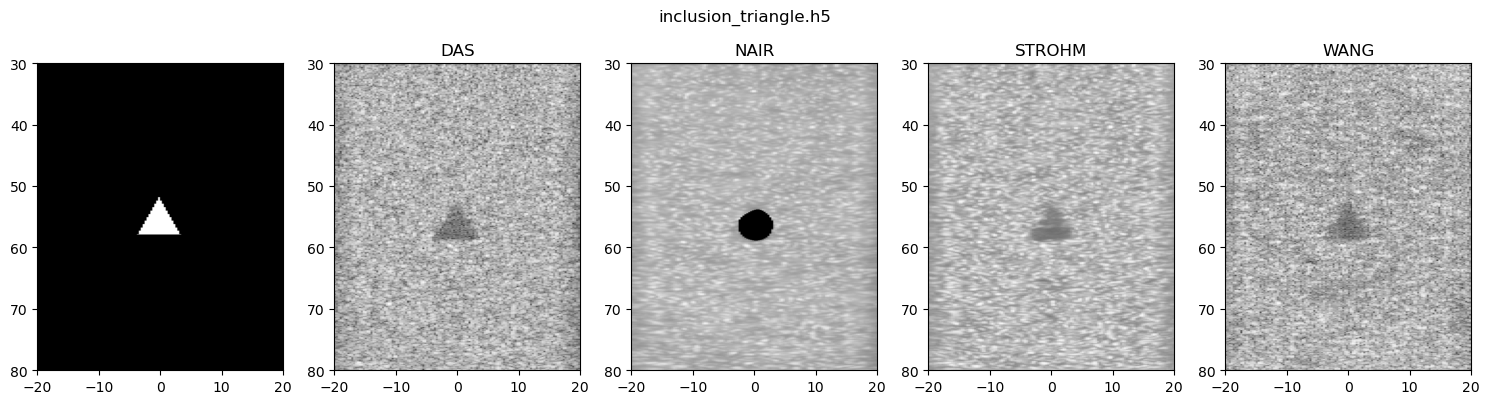

In [89]:
# ------ Plotting reconstructions
nbeamformers = len(beamformers)
fig, ax = plt.subplots(nrows=1, ncols=nbeamformers, figsize=(3*nbeamformers, 4))
for counter, name in enumerate(beamformers):
    if counter==0:
        ax[counter].imshow(beamformers[name], cmap="gray", vmin=0, vmax=1, **opts)
        continue
    ax[counter].imshow(beamformers[name], cmap="gray", vmin=-60, vmax=0, **opts)
    ax[counter].set_title(name)
plt.suptitle('%s' % h5name)
plt.tight_layout()

In [93]:
# Generate segmentations
threshold = 0.55
nls = {}

segmentations = {}
for counter, name in enumerate(beamformers):
    if counter==0:
        continue
    bmode = beamformers[name]
    bmode_img = (bmode + 60) / 60
    bmode_nl = denoise_nl_means(bmode_img,
                                h=0.01,
                                patch_size=3,
                                patch_distance=5,
                                sigma=9,
                                preserve_range=True)
    roi_comp = bmode_nl<threshold
    nls[name] = bmode_nl
    segmentations[name] = roi_comp

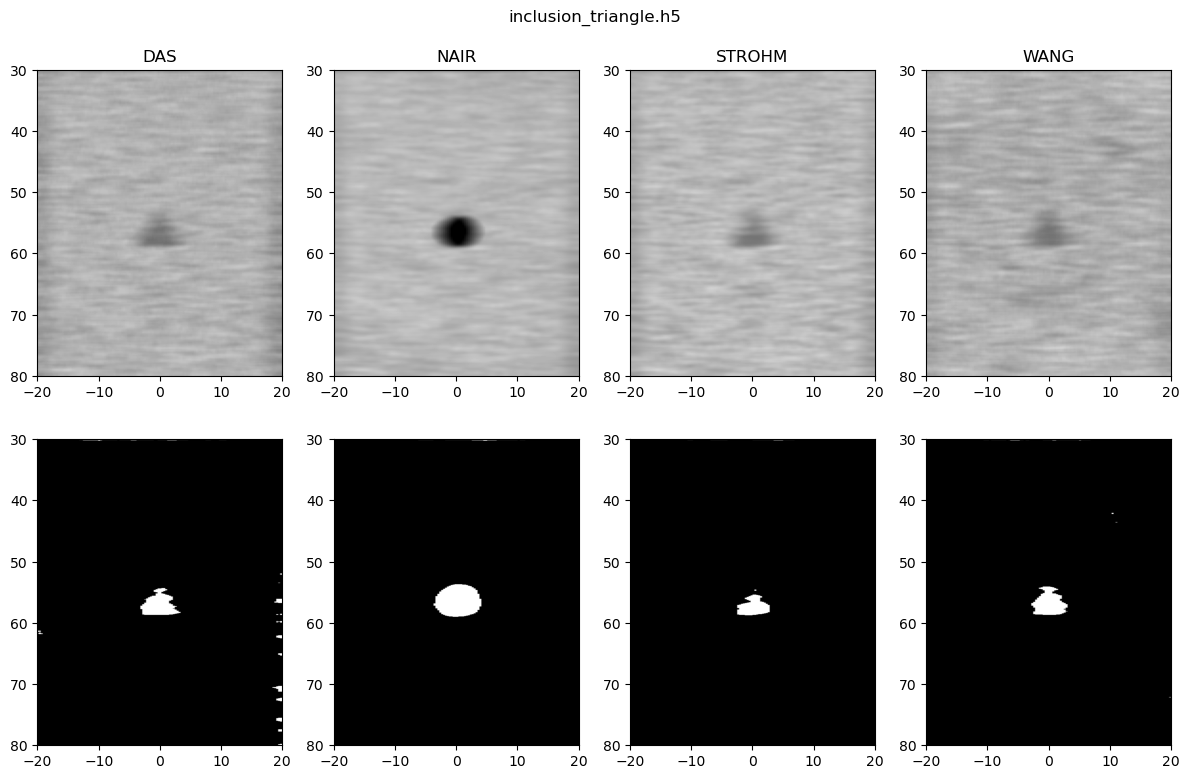

In [94]:
# ------ Plotting segmentations
nsegs = len(segmentations)
fig, ax = plt.subplots(nrows=2, ncols=nsegs, figsize=(3*nsegs, 8))
for counter, name in enumerate(segmentations):
    ax[0, counter].set_title(name)
    ax[0, counter].imshow(nls[name], cmap="gray", vmin=0, vmax=1, **opts)
    ax[1, counter].imshow(segmentations[name], cmap="gray", vmin=0, vmax=1, **opts)
plt.suptitle('%s' % h5name)
plt.tight_layout()

In [95]:
ms_ssim_list = {}
roi_ref = beamformers['ROI']
msssim_ref = torch.from_numpy((roi_ref[None, None, :]*1.0).astype('float32'))
    
for counter, name in enumerate(segmentations):
    roi_comp= segmentations[name]
    msssim_comp = torch.from_numpy((roi_comp[None, None, :]*1.0).astype('float32'))
    ms_ssim_list[name] = ms_ssim(msssim_ref, msssim_comp).item()
    # print(ms_ssim(msssim_ref, msssim_comp).item())
ms_ssim_list

{'DAS': 0.9207271933555603,
 'NAIR': 0.9353384971618652,
 'STROHM': 0.9190104603767395,
 'WANG': 0.938788652420044}